In [ ]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [ ]:
#clear df
import gc

for var in list(globals()):
    if var.startswith('df'):
        del globals()[var]

gc.collect()

20

In [ ]:
# combined 4 month files

files = [
    'yellow_tripdata_2024-02.csv',
    'yellow_tripdata_2024-06.csv',
    'yellow_tripdata_2024-09.csv',
    'yellow_tripdata_2024-12.csv'
]

dfs = []
#df_uc = dataframe_uncleaned
#add label column 'month' as '2024-??' to find if needed
for file in files:
    df_uc = pd.read_csv(file)
    df_uc['month'] = file.split('_')[-1].replace('.csv', '')
    dfs.append(df_uc)

combined_df = pd.concat(dfs, ignore_index=True)

C:\Users\mm921\AppData\Local\Temp\ipykernel_25572\2754775955.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uc = pd.read_csv(file)
C:\Users\mm921\AppData\Local\Temp\ipykernel_25572\2754775955.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uc = pd.read_csv(file)
C:\Users\mm921\AppData\Local\Temp\ipykernel_25572\2754775955.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uc = pd.read_csv(file)
C:\Users\mm921\AppData\Local\Temp\ipykernel_25572\2754775955.py:14: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_uc = pd.read_csv(file)


In [ ]:
# keep the selected features
selected_columns = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
    'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
    'fare_amount', 'tip_amount', 'tolls_amount', 'congestion_surcharge'
]

files = [
    'yellow_tripdata_2024-02.csv',
    'yellow_tripdata_2024-06.csv',
    'yellow_tripdata_2024-09.csv',
    'yellow_tripdata_2024-12.csv'
]

dfs = []
#df_uc = dataframe_uncleaned

for file in files:
    df_uc = pd.read_csv(file, usecols=selected_columns, low_memory=False)
    df_uc['month'] = file.split('_')[-1].replace('.csv', '')  # #add label column 'month' as '2024-??' to find if needed
    dfs.append(df_uc)

combined_df = pd.concat(dfs, ignore_index=True)

print(f"Combined dataframe shape: {combined_df.shape}")
print("Columns:", combined_df.columns.tolist())

Combined dataframe shape: (13848120, 12)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount', 'congestion_surcharge', 'month']


In [ ]:
combined_df.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,congestion_surcharge,month
0,2024-02-01 00:04:45,2024-02-01 00:19:58,1.0,4.39,68,236,1,20.5,1.28,0.00,2.5,2024-02
1,2024-02-01 00:56:31,2024-02-01 01:10:53,1.0,7.71,48,243,1,31.0,9.00,0.00,2.5,2024-02
2,2024-02-01 00:07:50,2024-02-01 00:43:12,2.0,28.69,132,261,2,70.0,0.00,6.94,2.5,2024-02
3,2024-02-01 00:01:49,2024-02-01 00:10:47,1.0,1.10,161,163,1,9.3,2.85,0.00,2.5,2024-02
4,2024-02-01 00:37:35,2024-02-01 00:51:15,1.0,2.60,246,79,2,15.6,0.00,0.00,2.5,2024-02


According to the large dataset, here we filtered the data by
- area zone : Manhattan
- time :9:00-18:00

In [ ]:
zone_lookup = pd.read_csv('taxi_zone_lookup.csv')

# find 'Manhattan' location IDs
manhattan_zones = zone_lookup[zone_lookup['Borough'] == 'Manhattan']['LocationID'].unique()
print(f"Number of Manhattan zones: {len(manhattan_zones)}")

# pickup time change into datetime
combined_df['tpep_pickup_datetime'] = pd.to_datetime(combined_df['tpep_pickup_datetime'])

# filtered only zone in manhattan
filtered_df = combined_df[combined_df['PULocationID'].isin(manhattan_zones)]

# filtered time range
filtered_df = filtered_df[
    (filtered_df['tpep_pickup_datetime'].dt.hour >= 9) &
    (filtered_df['tpep_pickup_datetime'].dt.hour <= 18)
]

print(f"Filtered dataframe shape: {filtered_df.shape}")

Number of Manhattan zones: 69
Filtered dataframe shape: (6958198, 12)


In [ ]:
filtered_df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime            object
passenger_count                 float64
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
tip_amount                      float64
tolls_amount                    float64
congestion_surcharge            float64
month                            object
dtype: object

In [ ]:
#filtered_df -> df2
df2 = filtered_df.copy()

- check missing values and filled with Unknown or -1

In [ ]:
check_cols = ['passenger_count', 'PULocationID', 'DOLocationID', 'payment_type', 'month']

# check missing/NA data amounts
for col in check_cols:
    na_count = df2[col].isna().sum()
    print(f"Column '{col}' has {na_count} missing values")

# deal with missing data
# For passenger_count, filled with one passenger ('1')
df2['passenger_count'] = df2['passenger_count'].fillna(1)

# For ID and category columnsm filled with '-1' or 'Unknown'
for col in ['PULocationID', 'DOLocationID', 'payment_type']:
    if df2[col].dtype.name == 'category':
        if 'Unknown' not in df2[col].cat.categories:
            df2[col] = df2[col].cat.add_categories(['Unknown'])
        df2[col] = df2[col].fillna('Unknown')
    elif df2[col].dtype.kind in 'iufc':  # numeric
        df2[col] = df2[col].fillna(-1)
    else:  # string and object
        df2[col] = df2[col].fillna('Unknown')

# For month, filled with 'Unknown'
if df2['month'].dtype.name == 'category':
    if 'Unknown' not in df2['month'].cat.categories:
        df2['month'] = df2['month'].cat.add_categories(['Unknown'])
df2['month'] = df2['month'].fillna('Unknown')

# change type
df2['tpep_dropoff_datetime'] = pd.to_datetime(df2['tpep_dropoff_datetime'])
df2['passenger_count'] = df2['passenger_count'].astype('int8')
df2['PULocationID'] = df2['PULocationID'].astype('category')
df2['DOLocationID'] = df2['DOLocationID'].astype('category')
df2['payment_type'] = df2['payment_type'].astype('category')
df2['month'] = df2['month'].astype('category')

print("NaN handling and type conversion completed!")

Column 'passenger_count' has 546254 missing values
Column 'PULocationID' has 0 missing values
Column 'DOLocationID' has 0 missing values
Column 'payment_type' has 0 missing values
Column 'month' has 0 missing values
NaN handling and type conversion completed!


In [ ]:
# check all column missing rate

missing_ratio = df2.isnull().sum() / len(df2) * 100

missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)

print("Missing Data Overview:")
print(missing_ratio)

Missing Data Overview:
congestion_surcharge    7.85051
dtype: float64


In [ ]:
df2['congestion_surcharge'] = df2['congestion_surcharge'].fillna(0)

In [ ]:
df2.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                    int8
trip_distance                   float64
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
tip_amount                      float64
tolls_amount                    float64
congestion_surcharge            float64
month                          category
dtype: object

In [ ]:
print(df2.head(5))
print(df2.tail(5))

      tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
9190   2024-02-01 09:01:09   2024-02-01 09:44:36                1   
9605   2024-02-01 09:00:23   2024-02-01 09:06:40                1   
9674   2024-02-01 09:00:37   2024-02-01 09:07:02                1   
13380  2024-02-01 09:00:39   2024-02-01 09:03:10                1   
13480  2024-02-01 09:00:42   2024-02-01 09:15:26                3   

       trip_distance PULocationID DOLocationID payment_type  fare_amount  \
9190            7.70          238          231            1         45.7   
9605            0.67          237          162            1          7.2   
9674            1.58          143          246            1          9.3   
13380           0.51          164          170            1          5.1   
13480           1.68          142          162            1         14.2   

       tip_amount  tolls_amount  congestion_surcharge    month  
9190         4.00           0.0                   2.5  2024-02 

In [ ]:
# remove duplicate columns/columns with no analytical significance.
duplicate_rows = df2.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}" )

df2 = df2.drop_duplicates()

Duplicate rows: 32


In [ ]:
# df2.to_csv("cleaned_data_taxi.csv", index = False)
# print("cleaned data is saved!")

### Descriptive Table (numeric)

In [ ]:
from IPython.display import display
numeric_columns = df2.select_dtypes(include=['int64', 'float64']).columns
interval_columns = df2.select_dtypes(include=['datetime64[ns]']).columns

print("1. Show continuous features:")
print("Numeric Columns:", numeric_columns)
print("Datetime Columns:", interval_columns)

print("2. Descriptive statistics table - continuous features")

numeric_sum = df2[numeric_columns].describe().T

interval_sum = df2[interval_columns].describe().T

table_continuous = pd.concat([numeric_sum, interval_sum])

# display(table_continuous)

con_columns = list(numeric_columns) + list(interval_columns)
df_table_continuous = df2[con_columns].describe(include="all").T

display(df_table_continuous)

1. Show continuous features:
Numeric Columns: Index(['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount',
       'congestion_surcharge'],
      dtype='object')
Datetime Columns: Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], dtype='object')
2. Descriptive statistics table - continuous features


,count,mean,min,25%,50%,75%,max,std
trip_distance,6958166.0,3.331286,0.0,0.9,1.49,2.45,330397.59,316.233313
fare_amount,6958166.0,16.248202,-748.5,8.6,12.8,19.8,3328.7,13.79149
tip_amount,6958166.0,2.939431,-99.01,0.0,2.62,4.05,544.76,3.201753
tolls_amount,6958166.0,0.2639,-70.38,0.0,0.0,0.0,476.35,1.709872
congestion_surcharge,6958166.0,2.174253,-2.5,2.5,2.5,2.5,2.5,0.931474
tpep_pickup_datetime,6958166,2024-07-31 20:08:28.304670720,2009-01-01 14:02:23,2024-06-04 14:09:43,2024-09-04 14:38:21.500000,2024-12-03 14:41:02.750000128,2025-03-02 11:38:31,NaN
tpep_dropoff_datetime,6958166,2024-07-31 20:24:56.350181376,2009-01-01 14:28:23,2024-06-04 14:27:34,2024-09-04 14:55:28.500000,2024-12-03 14:59:26,2025-03-02 12:12:43,NaN


<mark>Observation</mark>
1. There exist amount < 0, which is irregular
2. datetime should between 2024/02/01 ~ 2024/12/31

In [ ]:
# filtered irregular amount (<0)
amount_cols = ['fare_amount', 'tip_amount', 'tolls_amount', 'congestion_surcharge']
for col in amount_cols:
    invalid_count = (df2[col] < 0).sum()
    print(f"{col} has {invalid_count} negative values")

# delete amount
for col in amount_cols:
    df2 = df2[df2[col] >= 0]

# filtered irregular datetime（NOT 2024-02 ~ 2024-12）
valid_start = pd.Timestamp('2024-02-01')
valid_end = pd.Timestamp('2025-01-01')

invalid_dates = df2[
    (df2['tpep_pickup_datetime'] < valid_start) |
    (df2['tpep_pickup_datetime'] > valid_end) |
    (df2['tpep_dropoff_datetime'] < valid_start) |
    (df2['tpep_dropoff_datetime'] > valid_end)
]

print(f"Found {invalid_dates.shape[0]} rows with invalid dates")

# delete datetime
df2 = df2[
    (df2['tpep_pickup_datetime'] >= valid_start) &
    (df2['tpep_pickup_datetime'] < valid_end) &
    (df2['tpep_dropoff_datetime'] >= valid_start) &
    (df2['tpep_dropoff_datetime'] < valid_end)
]

print(f"After cleaning, dataframe shape: {df2.shape}")

fare_amount has 110319 negative values
tip_amount has 125 negative values
tolls_amount has 3073 negative values
congestion_surcharge has 88724 negative values
Found 22 rows with invalid dates
After cleaning, dataframe shape: (6847304, 12)


In [ ]:
df2.tail(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,congestion_surcharge,month
13841294,2024-12-31 18:46:03,2024-12-31 19:10:04,1,0.00,161,48,0,3.72,0.00,0.0,0.0,2024-12
13841295,2024-12-31 18:34:38,2024-12-31 18:38:31,1,0.49,13,231,0,31.76,7.15,0.0,0.0,2024-12
13841297,2024-12-31 18:52:31,2024-12-31 19:02:10,1,0.00,246,186,0,1.05,0.00,0.0,0.0,2024-12
13841300,2024-12-31 18:42:22,2024-12-31 19:05:14,1,0.00,4,141,0,23.66,5.53,0.0,0.0,2024-12
13841301,2024-12-31 18:42:17,2024-12-31 19:00:20,1,2.24,163,234,0,28.49,6.50,0.0,0.0,2024-12


In [23]:
#After cleaning
print("1. Show continuous features:")
print("Numeric Columns:", numeric_columns)
print("Datetime Columns:", interval_columns)

print("2. Descriptive statistics table - continuous features")

numeric_sum = df2[numeric_columns].describe().T

interval_sum = df2[interval_columns].describe().T

table_continuous = pd.concat([numeric_sum, interval_sum])

# display(table_continuous)

con_columns = list(numeric_columns) + list(interval_columns)
df_table_continuous = df2[con_columns].describe(include="all").T

display(df_table_continuous)

1. Show continuous features:
Numeric Columns: Index(['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount',
       'congestion_surcharge'],
      dtype='object')
Datetime Columns: Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], dtype='object')
2. Descriptive statistics table - continuous features


,count,mean,min,25%,50%,75%,max,std
trip_distance,6847304.0,3.297657,0.0,0.9,1.49,2.46,330397.59,311.700988
fare_amount,6847304.0,16.744558,0.0,9.3,13.5,19.8,3328.7,13.134819
tip_amount,6847304.0,2.98635,0.0,0.0,2.66,4.06,544.76,3.202531
tolls_amount,6847304.0,0.272515,0.0,0.0,0.0,0.0,476.35,1.704668
congestion_surcharge,6847304.0,2.24184,0.0,2.5,2.5,2.5,2.5,0.760759
tpep_pickup_datetime,6847304,2024-07-31 13:05:13.954701056,2024-02-01 09:00:00,2024-06-04 13:01:32.500000,2024-09-04 13:20:34,2024-12-03 13:57:26,2024-12-31 18:59:59,NaN
tpep_dropoff_datetime,6847304,2024-07-31 13:21:44.410800896,2024-02-01 09:00:43,2024-06-04 13:19:14,2024-09-04 13:39:06.500000,2024-12-03 14:17:10,2024-12-31 22:04:32,NaN


In [24]:
#tolls_amount "mean" is so low here '0.272914', check distribution
has_toll = (df2['tolls_amount'] > 0).mean() * 100
print(f"Percentage of trips with tolls: {has_toll:.2f}%")

Percentage of trips with tolls: 3.21%


According to the low percentage of trips with tolls and irrelevant of busyness and tip amount, we decide to drop column "tolls_amount" and "tip_amount" here

In [25]:
df2 = df2.drop(columns=['tolls_amount'])
print("Dropped 'tolls_amount'. Remaining columns:", df2.columns.tolist())

Dropped 'tolls_amount'. Remaining columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'tip_amount', 'congestion_surcharge', 'month']


In [26]:
df2 = df2.drop(columns=['tip_amount'])
print("Dropped 'tip_amount'. Remaining columns:", df2.columns.tolist())

Dropped 'tip_amount'. Remaining columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'congestion_surcharge', 'month']


In [27]:
#remaining columns and types
df2.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                    int8
trip_distance                   float64
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
congestion_surcharge            float64
month                          category
dtype: object

In [28]:
# check again %missing column
numeric_columns = df2.select_dtypes(include=['int64', 'float64']).columns
interval_columns = df2.select_dtypes(include=['datetime64[ns]']).columns

continuous_columns = list(numeric_columns) + list(interval_columns)
continuous_columns_missing  = 100 * (df2[continuous_columns].isnull().sum()/df2.shape[0])
# store the values in a dataframe
df_continuous_columns_missing = pd.DataFrame(continuous_columns_missing, columns=['%missing'])
display(df_continuous_columns_missing)

,%missing
trip_distance,0.0
fare_amount,0.0
congestion_surcharge,0.0
tpep_pickup_datetime,0.0
tpep_dropoff_datetime,0.0


In [29]:
# Add cardinality column
# A simpler way to get the number of unique values per feature
continuous_columns_card = df2[continuous_columns].nunique()
# store the values in a dataframe
df_continuous_card = pd.DataFrame(continuous_columns_card, columns=['card'])
df_continuous_card

,card
trip_distance,3867
fare_amount,10427
congestion_surcharge,2
tpep_pickup_datetime,3358241
tpep_dropoff_datetime,3403184


In [30]:
# transform type 'congestion_surchage' to binary(0/1)
# Create binary feature: has_congestion_surcharge
df2['has_congestion_surcharge'] = (df2['congestion_surcharge'] > 0).astype(int)

#check distribution
surcharge_counts = df2['has_congestion_surcharge'].value_counts()
print("Has Congestion Surcharge (0 = no, 1 = yes):")
print(surcharge_counts)

# Drop original column
df2 = df2.drop(columns=['congestion_surcharge'])
print("Dropped original 'congestion_surcharge' column.")


Has Congestion Surcharge (0 = no, 1 = yes):
has_congestion_surcharge
1    6140223
0     707081
Name: count, dtype: int64
Dropped original 'congestion_surcharge' column.


<mark>Transform datatime fields into features</mark>
1. Raw datetime columns like tpep_pickup_datetime or tpep_dropoff_datetime are not directly meaningful to machine learning models.
2. Models can’t inherently understand or extract useful patterns from full timestamp strings like “2024-06-15 14:23:00”.
So, we break down these datetime fields into interpretable numeric or categorical components such as:
- Hour of the day (e.g., morning, afternoon, night)
- Day of the week (e.g., weekday vs weekend)
- Month (seasonal trends)
- Is weekend flag (binary: 0 or 1)

In [31]:
#pickup time features
df2['pickup_hour'] = df2['tpep_pickup_datetime'].dt.hour
df2['pickup_weekday'] = df2['tpep_pickup_datetime'].dt.weekday
df2['pickup_is_weekend'] = (df2['pickup_weekday'] >= 5).astype(int)
df2['pickup_month'] = df2['tpep_pickup_datetime'].dt.month

print(df2[['pickup_hour', 'pickup_weekday', 'pickup_is_weekend', 'pickup_month']].head())

       pickup_hour  pickup_weekday  pickup_is_weekend  pickup_month
9190             9               3                  0             2
9605             9               3                  0             2
9674             9               3                  0             2
13380            9               3                  0             2
13480            9               3                  0             2


In [32]:
#dropoff time features
df2['dropoff_hour'] = df2['tpep_dropoff_datetime'].dt.hour
df2['dropoff_weekday'] = df2['tpep_dropoff_datetime'].dt.weekday
df2['dropoff_is_weekend'] = (df2['dropoff_weekday'] >= 5).astype(int)
df2['dropoff_month'] = df2['tpep_dropoff_datetime'].dt.month

print(df2[['dropoff_hour', 'dropoff_weekday', 'dropoff_is_weekend', 'dropoff_month']].head())

       dropoff_hour  dropoff_weekday  dropoff_is_weekend  dropoff_month
9190              9                3                   0              2
9605              9                3                   0              2
9674              9                3                   0              2
13380             9                3                   0              2
13480             9                3                   0              2


In [33]:
df2.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,month,has_congestion_surcharge,pickup_hour,pickup_weekday,pickup_is_weekend,pickup_month,dropoff_hour,dropoff_weekday,dropoff_is_weekend,dropoff_month
9190,2024-02-01 09:01:09,2024-02-01 09:44:36,1,7.70,238,231,1,45.7,2024-02,1,9,3,0,2,9,3,0,2
9605,2024-02-01 09:00:23,2024-02-01 09:06:40,1,0.67,237,162,1,7.2,2024-02,1,9,3,0,2,9,3,0,2
9674,2024-02-01 09:00:37,2024-02-01 09:07:02,1,1.58,143,246,1,9.3,2024-02,1,9,3,0,2,9,3,0,2
13380,2024-02-01 09:00:39,2024-02-01 09:03:10,1,0.51,164,170,1,5.1,2024-02,1,9,3,0,2,9,3,0,2
13480,2024-02-01 09:00:42,2024-02-01 09:15:26,3,1.68,142,162,1,14.2,2024-02,1,9,3,0,2,9,3,0,2


In [34]:
df2.tail(3)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,month,has_congestion_surcharge,pickup_hour,pickup_weekday,pickup_is_weekend,pickup_month,dropoff_hour,dropoff_weekday,dropoff_is_weekend,dropoff_month
13841297,2024-12-31 18:52:31,2024-12-31 19:02:10,1,0.00,246,186,0,1.05,2024-12,0,18,1,0,12,19,1,0,12
13841300,2024-12-31 18:42:22,2024-12-31 19:05:14,1,0.00,4,141,0,23.66,2024-12,0,18,1,0,12,19,1,0,12
13841301,2024-12-31 18:42:17,2024-12-31 19:00:20,1,2.24,163,234,0,28.49,2024-12,0,18,1,0,12,19,1,0,12


### Descriptive Table (categorical)

In [35]:
print("1. Descriptive statistics table - categorical features")
cat_columns = df2.select_dtypes(include=["category", "object"]).columns
df_table_categ = df2[cat_columns].describe(include="all").T
display(df_table_categ)

1. Descriptive statistics table - categorical features


,count,unique,top,freq
PULocationID,6847304,67,237,430806
DOLocationID,6847304,261,237,388258
payment_type,6847304,5,1,5232921
month,6847304,4,2024-12,1843860


In [36]:
#missing data
# Prepare %missing column
category_columns_perc_missing  = 100 * (df2[cat_columns].isnull().sum()/df2.shape[0])
#category_columns_perc_missing

# Store the values in a dataframe
df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
df_category_perc_missing

,%missing
PULocationID,0.0
DOLocationID,0.0
payment_type,0.0
month,0.0


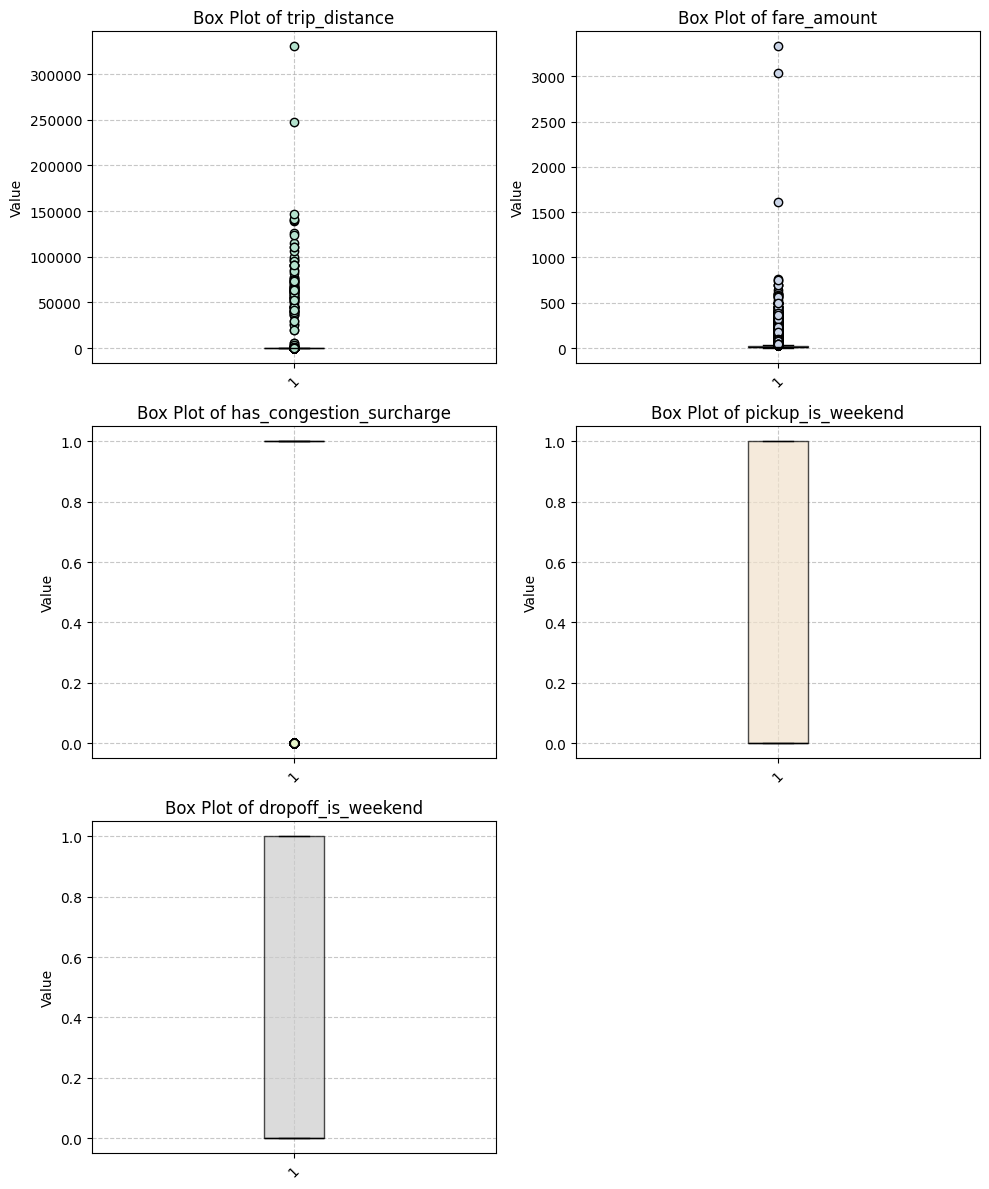

In [37]:
#continuous variable columns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

continuous_column = df2.select_dtypes(include=['int64', 'float64']).columns

n_features = len(continuous_column)
n_rows = (n_features + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4*n_rows))
axes = axes.ravel()

# Set color cycle
colors = plt.cm.Pastel2(np.linspace(0, 1, n_features))

with PdfPages('Continuous_boxplots.pdf') as pp:

    # Create box plots for each feature
    for idx, (column, color) in enumerate(zip(continuous_column, colors)):
        # Ensure data is numeric and drop null values
        data = df2[column].dropna().astype(float)
        

        box_plot = axes[idx].boxplot(data,
                                    patch_artist=True,
                                    medianprops={'color': 'black'},
                                    flierprops={'marker': 'o',
                                            'markerfacecolor': color,
                                            'markeredgecolor': 'black'},
                                    boxprops={'facecolor': color,
                                            'alpha': 0.7})
        
        axes[idx].set_title(f'Box Plot of {column}')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, linestyle='--', alpha=0.7)
        
        axes[idx].tick_params(axis='x', rotation=45)

    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])
        
fig.savefig("Continuous_boxplots.pdf")
plt.tight_layout()
plt.show()


In [38]:
#outliers can deal or just ignore now
# df2['is_high_fare'] = (df2['fare_amount'] > df2['fare_amount'].quantile(0.99)).astype(int)
# df2['is_long_trip'] = (df2['trip_distance'] > df2['trip_distance'].quantile(0.99)).astype(int)

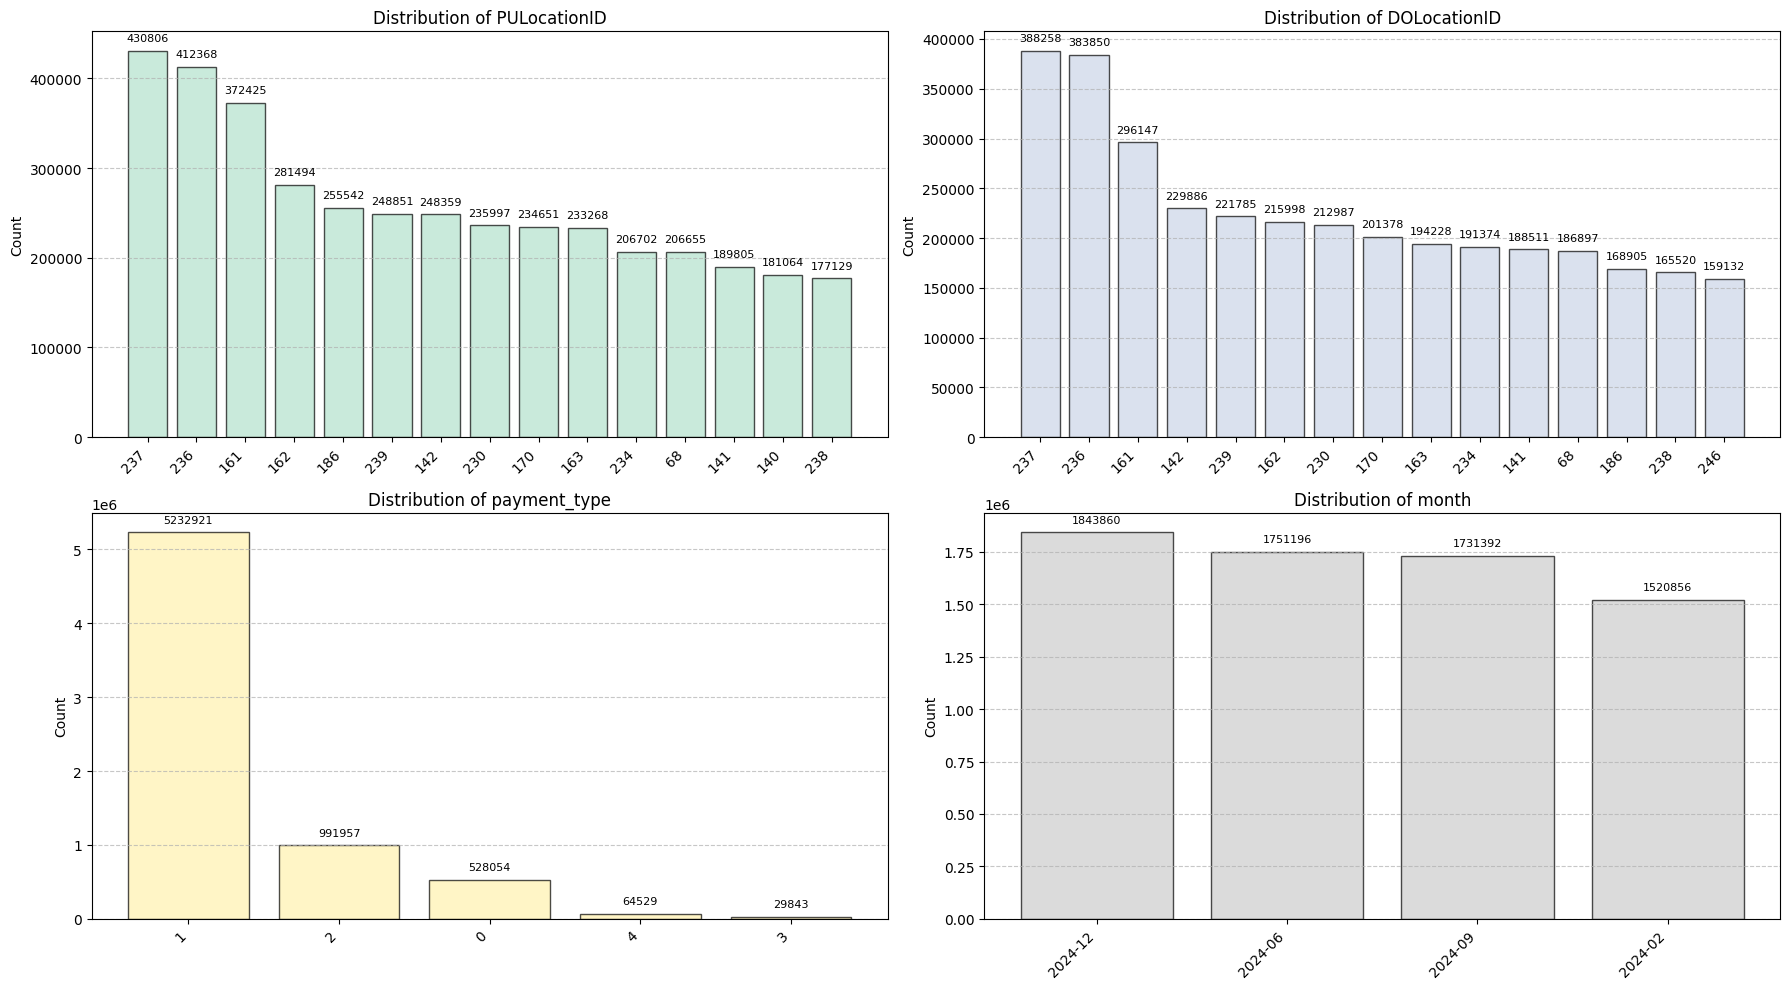

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

categorical_column = df2.select_dtypes(include=['object', 'category']).columns
n_features = len(categorical_column)
n_rows = (n_features + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(18, 5 * n_rows))
axes = axes.ravel()


colors = plt.cm.Pastel2(np.linspace(0, 1, min(n_features, 8)))


with PdfPages('categorical_barplots.pdf') as pp:
    for idx, column in enumerate(categorical_column):
        if idx >= len(axes):
            break

        value_counts = df2[column].value_counts(dropna=False)[:15]

        axes[idx].bar(value_counts.index.astype(str),
                    value_counts.values,
                    color=colors[idx % len(colors)], alpha=0.7, edgecolor='black')

        axes[idx].set_xticks(range(len(value_counts.index)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)
        axes[idx].set_title(f'Distribution of {column}', fontsize=12)
        axes[idx].set_ylabel('Count', fontsize=10)
        axes[idx].grid(True, linestyle='--', alpha=0.7, axis='y')


        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + max(value_counts.values) * 0.02, str(v), ha='center', va='bottom', fontsize=8)


    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    pp.savefig(fig)
    plt.show()

In [40]:
# use one-hot-encoding

# Define columns to one-hot encode
one_hot_columns = ['PULocationID', 'DOLocationID', 'payment_type', 'month']

# Apply one-hot encoding
df2_onehot = pd.get_dummies(df2, columns=one_hot_columns, drop_first=True)

print("One-hot encoding completed!")
print(f"New dataframe shape: {df2_onehot.shape}")

One-hot encoding completed!
New dataframe shape: (6847304, 347)


In [41]:
df2_onehot.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,has_congestion_surcharge,pickup_hour,pickup_weekday,pickup_is_weekend,pickup_month,...,DOLocationID_263,DOLocationID_264,DOLocationID_265,payment_type_1,payment_type_2,payment_type_3,payment_type_4,month_2024-06,month_2024-09,month_2024-12
9190,2024-02-01 09:01:09,2024-02-01 09:44:36,1,7.70,45.7,1,9,3,0,2,...,False,False,False,True,False,False,False,False,False,False
9605,2024-02-01 09:00:23,2024-02-01 09:06:40,1,0.67,7.2,1,9,3,0,2,...,False,False,False,True,False,False,False,False,False,False
9674,2024-02-01 09:00:37,2024-02-01 09:07:02,1,1.58,9.3,1,9,3,0,2,...,False,False,False,True,False,False,False,False,False,False
13380,2024-02-01 09:00:39,2024-02-01 09:03:10,1,0.51,5.1,1,9,3,0,2,...,False,False,False,True,False,False,False,False,False,False
13480,2024-02-01 09:00:42,2024-02-01 09:15:26,3,1.68,14.2,1,9,3,0,2,...,False,False,False,True,False,False,False,False,False,False


In [42]:
df2.tail(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,month,has_congestion_surcharge,pickup_hour,pickup_weekday,pickup_is_weekend,pickup_month,dropoff_hour,dropoff_weekday,dropoff_is_weekend,dropoff_month
13841294,2024-12-31 18:46:03,2024-12-31 19:10:04,1,0.00,161,48,0,3.72,2024-12,0,18,1,0,12,19,1,0,12
13841295,2024-12-31 18:34:38,2024-12-31 18:38:31,1,0.49,13,231,0,31.76,2024-12,0,18,1,0,12,18,1,0,12
13841297,2024-12-31 18:52:31,2024-12-31 19:02:10,1,0.00,246,186,0,1.05,2024-12,0,18,1,0,12,19,1,0,12
13841300,2024-12-31 18:42:22,2024-12-31 19:05:14,1,0.00,4,141,0,23.66,2024-12,0,18,1,0,12,19,1,0,12
13841301,2024-12-31 18:42:17,2024-12-31 19:00:20,1,2.24,163,234,0,28.49,2024-12,0,18,1,0,12,19,1,0,12


### logical check

In [43]:
import pandas as pd
original_rows = df2.shape[0]

def report_filter(df, condition, description):
    before = df.shape[0]
    df = df[condition]
    after = df.shape[0]
    removed = before - after
    print(f"{description}: removed {removed} rows")
    return df

# 1. dropoff time later than pickup
df2 = df2[df2['tpep_dropoff_datetime'] > df2['tpep_pickup_datetime']]

# 2. distance > 0
df2 = df2[df2['trip_distance'] > 0]

# 3. amount ≥ 0
df2 = df2[df2['fare_amount'] >= 0]

# 4. passenger ≥ 1
df2 = df2[df2['passenger_count'] >= 1]

# 5. has_congestion_surcharge ∈ {0, 1}
df2 = df2[df2['has_congestion_surcharge'].isin([0, 1])]

# 6. time stamp
valid_start = pd.Timestamp('2024-02-01')
valid_end = pd.Timestamp('2025-01-01') - pd.Timedelta(seconds=1)
df2 = df2[
    (df2['tpep_pickup_datetime'] >= valid_start) & (df2['tpep_pickup_datetime'] <= valid_end) &
    (df2['tpep_dropoff_datetime'] >= valid_start) & (df2['tpep_dropoff_datetime'] <= valid_end)
]

print(f" After logic checks, dataframe shape: {df2.shape}")

 After logic checks, dataframe shape: (6660926, 18)


In [44]:
df2.tail(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,month,has_congestion_surcharge,pickup_hour,pickup_weekday,pickup_is_weekend,pickup_month,dropoff_hour,dropoff_weekday,dropoff_is_weekend,dropoff_month
13841289,2024-12-31 18:32:13,2024-12-31 18:43:53,1,3.30,87,4,0,1.14,2024-12,0,18,1,0,12,18,1,0,12
13841291,2024-12-31 18:39:49,2024-12-31 18:56:57,1,2.20,144,137,0,19.25,2024-12,0,18,1,0,12,18,1,0,12
13841292,2024-12-31 18:25:40,2024-12-31 19:09:49,1,7.80,107,42,0,39.80,2024-12,0,18,1,0,12,19,1,0,12
13841295,2024-12-31 18:34:38,2024-12-31 18:38:31,1,0.49,13,231,0,31.76,2024-12,0,18,1,0,12,18,1,0,12
13841301,2024-12-31 18:42:17,2024-12-31 19:00:20,1,2.24,163,234,0,28.49,2024-12,0,18,1,0,12,19,1,0,12


In [48]:
# Save the cleaned (non-one-hot) dataframe
cleaned_file_path = 'cleaned_data_taxi_tripdata.csv'
# df2.to_csv(cleaned_file_path, index=False)
df2.to_csv('cleaned_data_taxi_tripdata.csv')
print(f" Saved cleaned data to cleaned_data_taxi_tripdata.csv")

# Apply one-hot encoding
# one_hot_columns = ['PULocationID', 'DOLocationID', 'payment_type', 'month']
# df2_onehot = pd.get_dummies(df2, columns=one_hot_columns, drop_first=True)

# # Save the one-hot encoded dataframe
# onehot_file_path = 'cleaned_data_taxi_tripdata_onehot_data.csv'
# df2_onehot.to_csv(onehot_file_path, index=False)
# print(f"Saved one-hot encoded data to {onehot_file_path}")

 Saved cleaned data to cleaned_data_taxi_tripdata.csv


In [ ]:
df_combined.to_csv("taxi_with_zonenameid_complete.csv", index=False)
#少一天

In [66]:
# 建立新欄位 datetime
df2['datetime'] = pd.to_datetime(df2['tpep_pickup_datetime']).dt.floor('h')

# 合併區域名稱
df2 = df2.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
df2 = df2[df2['Zone'].notna()]

# 重命名與選擇欄位
df_zone = df2[['datetime', 'Zone', 'LocationID', 'passenger_count',
               'trip_distance', 'fare_amount', 'has_congestion_surcharge']].copy()

df_zone.rename(columns={
    'Zone': 'zone_name',
    'LocationID': 'zone_id'
}, inplace=True)

# 加上 transport_mode
df_zone['transport_mode'] = 'taxi'

# 重新排序欄位
df_zone = df_zone[['datetime', 'zone_name', 'zone_id', 'transport_mode',
                   'passenger_count', 'trip_distance', 'fare_amount', 'has_congestion_surcharge']]

# 儲存
df_zone.to_csv("taxi_with_zonenameid.csv", index=False)


C:\Users\mm921\AppData\Local\Temp\ipykernel_25572\2169056513.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2['datetime'] = pd.to_datetime(df2['tpep_pickup_datetime']).dt.floor('H')


In [63]:
import pandas as pd

# 讀入原本主檔（缺12/31）
df_existing = pd.read_csv("taxi_with_zonenameid.csv")
df_existing['datetime'] = pd.to_datetime(df_existing['datetime'])

# 讀入12月資料與lookup表
df_dec = pd.read_csv("yellow_tripdata_2024-12.csv", low_memory=False)
zone_lookup = pd.read_csv("taxi_zone_lookup.csv")

# 產生datetime欄位並過濾12/31
df_dec['datetime'] = pd.to_datetime(df_dec['tpep_pickup_datetime'], errors='coerce').dt.floor('H')
df_1231 = df_dec[df_dec['datetime'].dt.date == pd.to_datetime("2024-12-31").date()]

# 合併區域名稱
df_1231 = df_1231.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
df_1231 = df_1231[df_1231['Zone'].notna()]

# 選取欄位並改名
df_1231_final = df_1231[['datetime', 'Zone', 'LocationID', 'passenger_count',
                         'trip_distance', 'fare_amount', 'has_congestion_surcharge']].copy()

df_1231_final.rename(columns={
    'Zone': 'zone_name',
    'LocationID': 'zone_id',
}, inplace=True)

# 改欄位名稱為 transport_mode 並設為 'taxi'
df_1231_final['transport_mode'] = 'taxi'

# 調整欄位順序以符合主檔格式
df_1231_final = df_1231_final[['datetime', 'zone_name', 'zone_id', 'transport_mode',
                               'passenger_count', 'trip_distance', 'fare_amount', 'has_congestion_surcharge']]

# 合併並儲存
df_combined = pd.concat([df_existing, df_1231_final], ignore_index=True)
df_combined.to_csv("taxi_with_zonenameid_complete.csv", index=False)


C:\Users\mm921\AppData\Local\Temp\ipykernel_25572\3387688653.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_dec['datetime'] = pd.to_datetime(df_dec['tpep_pickup_datetime'], errors='coerce').dt.floor('H')


KeyError: "['has_congestion_surcharge'] not in index"

In [65]:
df_1231.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,datetime,LocationID,Borough,Zone,service_zone
0,2,2024-12-31 00:08:38,2024-12-31 00:30:45,1.0,6.18,1.0,N,230,116,2,...,0.00,1.0,34.60,2.5,0.0,2024-12-31,230.0,Manhattan,Times Sq/Theatre District,Yellow Zone
1,2,2024-12-31 00:00:10,2024-12-31 00:08:16,1.0,1.40,1.0,N,186,162,2,...,0.00,1.0,15.00,2.5,0.0,2024-12-31,186.0,Manhattan,Penn Station/Madison Sq West,Yellow Zone
2,1,2024-12-31 00:40:30,2024-12-31 00:40:56,1.0,0.00,1.0,N,142,142,3,...,0.00,1.0,8.00,2.5,0.0,2024-12-31,142.0,Manhattan,Lincoln Square East,Yellow Zone
5,2,2024-12-31 00:04:51,2024-12-31 00:28:30,2.0,4.67,1.0,N,164,255,1,...,6.94,1.0,43.13,2.5,0.0,2024-12-31,164.0,Manhattan,Midtown South,Yellow Zone
6,2,2024-12-31 00:06:32,2024-12-31 00:15:51,1.0,2.39,1.0,N,48,234,1,...,0.00,1.0,23.14,2.5,0.0,2024-12-31,48.0,Manhattan,Clinton East,Yellow Zone
